# Topic: Research Papers Categorization 

In this notebook i will be experimenting by creating two models:

- LSTM Model with Relu activate layer and Globalmax pooling for dimensionality reduction
- Bi-Directional LSTM Layer
- Different learning rates

# Step 1: Data Visualization


In this step i am checking for null values, distribution of labels and balance of the data across the labels

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Path of the :
- Test and Train data
- GloVe embedding file 
- Saved model

**change the path to run the experiement in your local**

In [2]:
train_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/train.csv')
test_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/test.csv')
modelpath_LSTMwithPoolandRelu="..\\NLPCourseWork\\models\\LSTMwithPoolandRelu.hdf5"
modelpath_BidirectionalLSTM="..\\NLPCourseWork\\models\\BidirectionalLSTM.hdf5"
glovepath_file='C:\\Users\\priyanka\\OneDrive - University of Surrey\\NLPCourseWork\\glove.6B.100d.txt'

In [3]:
print("Number of rows in data =",train_respapers.shape[0])
print("Number of columns in data =",train_respapers.shape[1])
print("\n")
print("**Sample data:**")
train_respapers.head()

Number of rows in data = 20972
Number of columns in data = 9


**Sample data:**


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
#check for missing values
missing_values_check = train_respapers.isnull().sum()
print("Check for Missing values:\n ")
print(missing_values_check)

Check for Missing values:
 
ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64


In [5]:
#Check for the Papers without labels
rowSums = train_respapers.iloc[:,3:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of papers = ",len(train_respapers))
print("Number of papers with labels =",(len(train_respapers)-clean_comments_count))

Total number of papers =  20972
Number of papers with labels = 20972


In [6]:
#print the list of Target labels
categories = list(train_respapers.columns.values)
categories = categories[3:]
print("List of Labels: ",categories)

List of Labels:  ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [7]:
# Calculating number of research papers in each category
counts = []
for category in categories:
    counts.append((category, train_respapers[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Research Category', 'Number of Papers'])
print(df_stats)

      Research Category  Number of Papers
0      Computer Science              8594
1               Physics              6013
2           Mathematics              5618
3            Statistics              5206
4  Quantitative Biology               587
5  Quantitative Finance               249


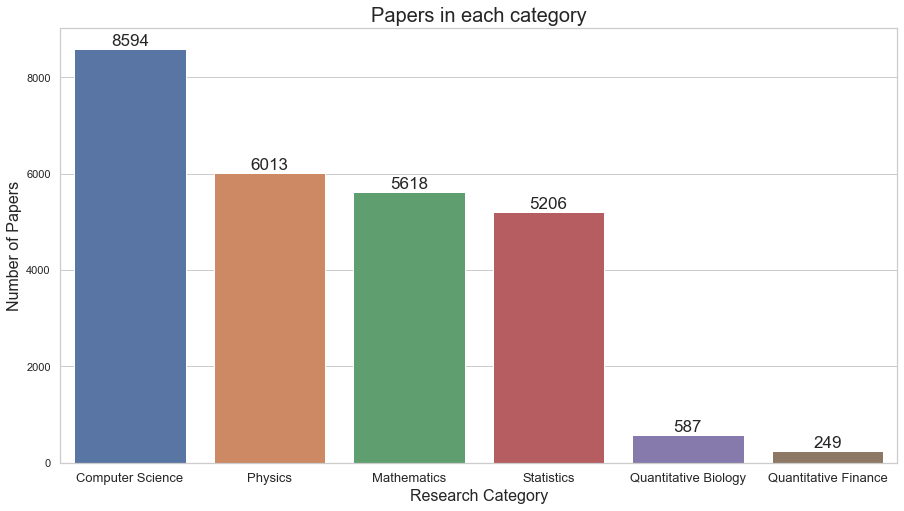

In [8]:

plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax= sns.barplot(x=categories, y=train_respapers.iloc[:,3:].sum().values)

plt.title("Papers in each category", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Research Category', fontsize=16)

#adding the text labels
rects = ax.patches
labels = train_respapers.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=17)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
plt.show()

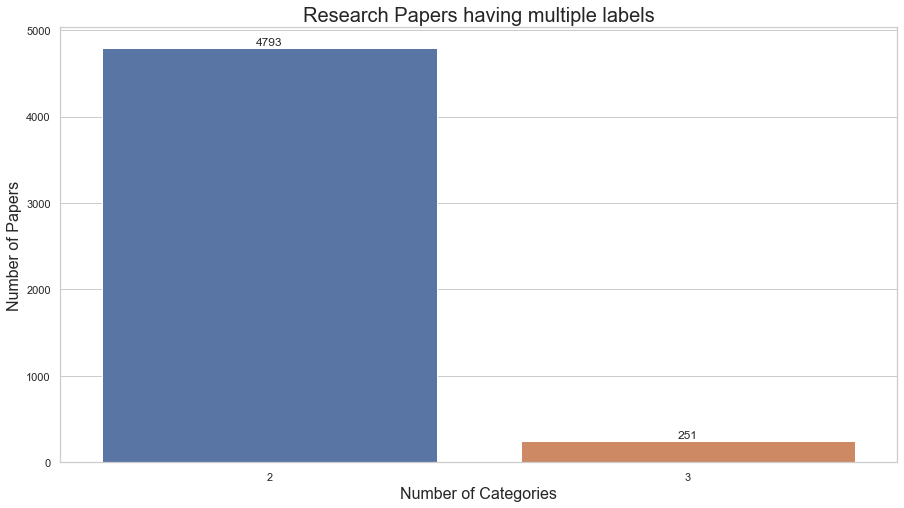

In [9]:
rowSums = train_respapers.iloc[:,2:].sum(axis=1)

multiLabel_counts = rowSums.value_counts().iloc[1:]

plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Research Papers having multiple labels", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Number of Categories', fontsize=16)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Step 2 : Data Preprocessing

I am performing below data preprocessing for input label which is ' **ABSTRACT** ':

- Remove Punctuation
- Decontracting the text

In [10]:
# Load the regular expression library and spacy library
import re
import spacy
import gensim
from gensim.utils import simple_preprocess
from nltk.tokenize.treebank import TreebankWordDetokenizer
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Remove punctuation
def remove_punctuation(text):
    text = re.sub('[,\.!?]', '', text)
    return text

#tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) 
        
#remove stopwords        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# decontract the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

#Lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priyanka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#decontracting the text()
train_respapers['ABSTRACT'] = train_respapers['ABSTRACT'].map(lambda com : clean_text(com))

#remove_punctuation()
train_respapers['ABSTRACT'] = train_respapers['ABSTRACT'].apply(lambda x: remove_punctuation(x))

# Print out the first rows of papers
train_respapers.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,predictive models allow subject-specific infer...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance and translation invariance...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,we introduce and develop the notion of spheric...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,the stochastic landau--lifshitz--gilbert (llg)...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fourier-transform infra-red (ftir) spectra of ...,1,0,0,1,0,0


In [13]:
research_labels = train_respapers[["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]]
research_labels_val=research_labels.values
print(research_labels_val)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


# Step 3: Prepare the Data

- Splitting the dataset
- Tokenizing the text with texts_to_sequence to transform words to numbers 
- Using Pad_sequences to ensure all the vectors are of same length
- Creating the embedding matrix with pre-trained word embedding GloVe

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
train_respapers['ABSTRACT'], research_labels_val, test_size=0.3, random_state=1234, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14680,)
(14680, 6)
(6292,)
(6292, 6)


In [15]:
#Split the text to tokens, using most 5000 frequent words and max len to 200
tokenizer = Tokenizer(num_words=5000,lower=True)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Vocabulary size is ",vocab_size)

Vocabulary size is  47336


In [16]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [17]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
     glovepath_file,
     tokenizer.word_index, embedding_dim)
print('found %s word vectors' % len(embedding_matrix))

found 47336 word vectors


# Step 4: Build the Model

- I am creating the model with configurable parameter of Bi-directional set to true or false

- Creating the sequential model with

  - Single LSTM layer with 0.2 of dropout to prevent the overfitting, Globalmaxpool and dense layer with Relu activation
  - Bi-directional layer to return_sequence set to true to return the last output
  - Dense layer with 6 outputs (6labels) with Sigmoid activation because my output is binary(0 or 1)


In [18]:
from keras import Sequential, Model
from keras.layers import Embedding,LSTM, GlobalMaxPool1D,Conv1D,Bidirectional
def get_model(bidirectional):
   
   
    model = Sequential()
   
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False,input_length=maxlen))
   
    model.add(Dropout(0.2))
    if(bidirectional==True):
        model.add(Bidirectional(LSTM(128,name='lstm_layer',return_sequences=True,dropout=0.2)))
    else:
        model.add(LSTM(128,name='lstm_layer',return_sequences=True,dropout=0.2))
    model.add(Dropout(0.2))
  
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(50,activation = 'relu'))
   
    model.add(Dense(6, activation='sigmoid'))
   
    return model
   
   

In [24]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
def fit_model(model,path,lr):
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    cm_callback = ModelCheckpoint(path, save_best_only = True, monitor = 'val_loss', verbose = 1)
#cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    if(lr==''):
        opt='adam'
    else:
        opt=Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2,
                  callbacks=[cm_callback],validation_data=(X_test, y_test))
    return(history)

In [20]:
model_LSTMwithPoolandRelu = get_model(bidirectional=False)
model_BidirectionalLSTM = get_model(bidirectional=True)
print(model_LSTMwithPoolandRelu.summary())
print(model_BidirectionalLSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          4733600   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 128)          117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

# Step 5: Train the Model

Defines below three function:

- Evaluate the model against the test data
- To calculate the confusion matrix
- Plot the metrics (loss vs epoch) and (accuracy vs epoch) for train and test data

In [21]:
import keras
def evaluate(path,msg):
    lstm_model = keras.models.load_model(path)
    test_evaluate = lstm_model.evaluate(X_test, y_test, verbose=1)
    print("Research Papers Test Score :" +msg, test_evaluate[0])
    print("Research Papers Test Accuracy :" +msg, test_evaluate[1])

In [22]:
from sklearn.metrics import multilabel_confusion_matrix,classification_report
def confusion_matrix(path,msg):
    lstm_model = keras.models.load_model(path)
    Y_pred = lstm_model.predict(X_test)
    Y_pred  = np.where(Y_pred > 0.5, 1, 0)
    print('Confusion Matrix of - ',msg)
    target_names = ['Computer Science', 'Physics', 'Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
    confusionmatrix=multilabel_confusion_matrix(y_test, Y_pred)
    print(confusionmatrix)
    print('Classification Report')
    print(classification_report(y_test, Y_pred, target_names=target_names,zero_division=0))
    print("confusion matrix function")

In [23]:
import matplotlib.pyplot as plt
def plotmetrics(history,msg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy - '+msg)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss - '+msg)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

**Fit Evaluate the model with single layer LSTM , pooling and Activate layer**

In [26]:
model_LSTMwithPoolandRelu_his=fit_model(model_LSTMwithPoolandRelu,modelpath_LSTMwithPoolandRelu,'')


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpjj225k5h.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpjj225k5h.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
367/367 [==============================] - 71s 145ms/step - loss: 0.3742 - accuracy: 0.5939 - val_loss: 0.2562 - val_accuracy: 0.7275

Epoch 00001: val_loss improved from inf to 0.25615, saving model to ..\NLPCourseWork\models\LSTMwithPoolandRelu.hdf5
Epoch 2/10
367/367 [==============================] - 57s 156ms/step - loss: 0.2501 - accuracy: 0.7282 - val_loss: 0.2334 - val_accur

In [27]:
print("The path of the saved model is "+modelpath_LSTMwithPoolandRelu)
evaluate(modelpath_LSTMwithPoolandRelu,"(Model with LSTM)")
confusion_matrix(modelpath_LSTMwithPoolandRelu,"for model with LSTM")

The path of the saved model is ..\NLPCourseWork\models\LSTMwithPoolandRelu.hdf5
197/197 [==============================] - 10s 46ms/step - loss: 0.1954 - accuracy: 0.7424
Research Papers Test Score :(Model with LSTM) 0.19539867341518402
Research Papers Test Accuracy :(Model with LSTM) 0.7423712611198425
Confusion Matrix of -  for model with LSTM
[[[3354  325]
  [ 603 2010]]

 [[4278  204]
  [ 276 1534]]

 [[4189  445]
  [ 269 1389]]

 [[4462  297]
  [ 497 1036]]

 [[6061   53]
  [ 111   67]]

 [[6201   15]
  [  46   30]]]
Classification Report
                      precision    recall  f1-score   support

    Computer Science       0.86      0.77      0.81      2613
             Physics       0.88      0.85      0.86      1810
         Mathematics       0.76      0.84      0.80      1658
          Statistics       0.78      0.68      0.72      1533
Quantitative Biology       0.56      0.38      0.45       178
Quantitative Finance       0.67      0.39      0.50        76

           mic

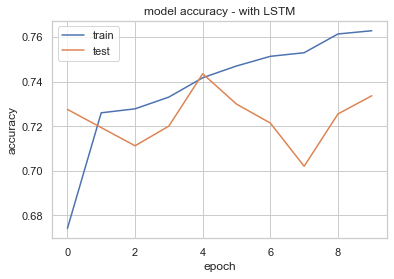

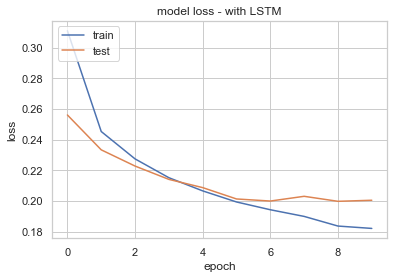

In [28]:
plotmetrics(model_LSTMwithPoolandRelu_his,"with LSTM")

**Fit and Evaluate the model for Bi-directional LSTM and experiementing on learning rates**

running the model for the learning rate  0.001
Epoch 1/10
367/367 [==============================] - 53s 134ms/step - loss: 0.1720 - accuracy: 0.7623 - val_loss: 0.1931 - val_accuracy: 0.7442

Epoch 00001: val_loss improved from inf to 0.19306, saving model to ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
Epoch 2/10
367/367 [==============================] - 49s 134ms/step - loss: 0.1683 - accuracy: 0.7726 - val_loss: 0.1951 - val_accuracy: 0.7388

Epoch 00002: val_loss did not improve from 0.19306
Epoch 3/10
367/367 [==============================] - 51s 138ms/step - loss: 0.1622 - accuracy: 0.7691 - val_loss: 0.1919 - val_accuracy: 0.7326

Epoch 00003: val_loss improved from 0.19306 to 0.19191, saving model to ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
Epoch 4/10
367/367 [==============================] - 50s 136ms/step - loss: 0.1587 - accuracy: 0.7689 - val_loss: 0.2011 - val_accuracy: 0.7374

Epoch 00004: val_loss did not improve from 0.19191
Epoch 5/10
367/367 [=============

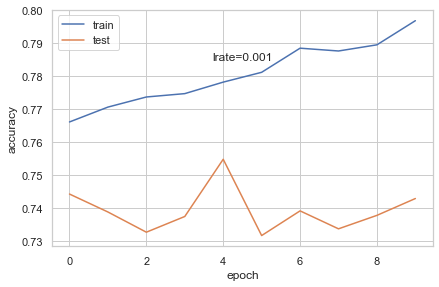

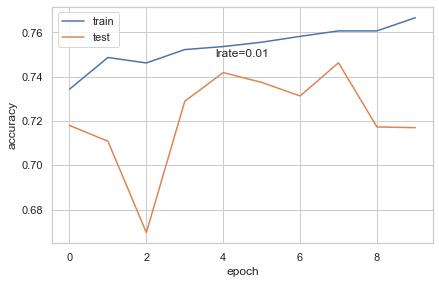

In [32]:
from matplotlib import pyplot
learning_rates = [0.001, 0.01]
for i in range(len(learning_rates)):
    print("running the model for the learning rate ",learning_rates[i])
    plot_no = 420 + (i+1)
    pyplot.figure(figsize=(15,20))
    pyplot.subplot(plot_no)
    model_BidirectionalLSTM_his=fit_model(model_BidirectionalLSTM,modelpath_BidirectionalLSTM,learning_rates[i])
    pyplot.plot(model_BidirectionalLSTM_his.history['accuracy'], label='train')
    pyplot.plot(model_BidirectionalLSTM_his.history['val_accuracy'], label='test')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    pyplot.title('lrate='+str(learning_rates[i]), pad=-50)
pyplot.show() 

Tried with experiementing two low learning rates,but it overfits with test data.But comparitively performs better with 0.01. Experiementing the models with default learning rate

In [29]:
model_BidirectionalLSTM_his=fit_model(model_BidirectionalLSTM,modelpath_BidirectionalLSTM,'')

Epoch 1/10
367/367 [==============================] - 72s 181ms/step - loss: 0.3989 - accuracy: 0.5359 - val_loss: 0.2612 - val_accuracy: 0.7091

Epoch 00001: val_loss improved from inf to 0.26117, saving model to ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
Epoch 2/10
367/367 [==============================] - 63s 173ms/step - loss: 0.2539 - accuracy: 0.7214 - val_loss: 0.2625 - val_accuracy: 0.6918

Epoch 00002: val_loss did not improve from 0.26117
Epoch 3/10
367/367 [==============================] - 66s 179ms/step - loss: 0.2292 - accuracy: 0.7307 - val_loss: 0.2212 - val_accuracy: 0.7415

Epoch 00003: val_loss improved from 0.26117 to 0.22115, saving model to ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
Epoch 4/10
367/367 [==============================] - 64s 174ms/step - loss: 0.2138 - accuracy: 0.7407 - val_loss: 0.2184 - val_accuracy: 0.7435

Epoch 00004: val_loss improved from 0.22115 to 0.21845, saving model to ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
Epoch 5/10
3

In [30]:
print("The path of the saved model is "+modelpath_BidirectionalLSTM)
evaluate(modelpath_BidirectionalLSTM,"(Model with Bidirectional-LSTM)")
confusion_matrix(modelpath_BidirectionalLSTM,"for model with Bidirectional-LSTM")

The path of the saved model is ..\NLPCourseWork\models\BidirectionalLSTM.hdf5
197/197 [==============================] - 9s 42ms/step - loss: 0.1925 - accuracy: 0.7537
Research Papers Test Score :(Model with Bidirectional-LSTM) 0.19246406853199005
Research Papers Test Accuracy :(Model with Bidirectional-LSTM) 0.7536554336547852
Confusion Matrix of -  for model with Bidirectional-LSTM
[[[3354  325]
  [ 534 2079]]

 [[4224  258]
  [ 216 1594]]

 [[4307  327]
  [ 314 1344]]

 [[4440  319]
  [ 417 1116]]

 [[6033   81]
  [  87   91]]

 [[6192   24]
  [  40   36]]]
Classification Report
                      precision    recall  f1-score   support

    Computer Science       0.86      0.80      0.83      2613
             Physics       0.86      0.88      0.87      1810
         Mathematics       0.80      0.81      0.81      1658
          Statistics       0.78      0.73      0.75      1533
Quantitative Biology       0.53      0.51      0.52       178
Quantitative Finance       0.60      0

I have displayed the outcome in confusion matrix with the labels. Detecting the labels but it overfits with test data. In below graph my loss also reduces and fluctuation in accuracy with test data.

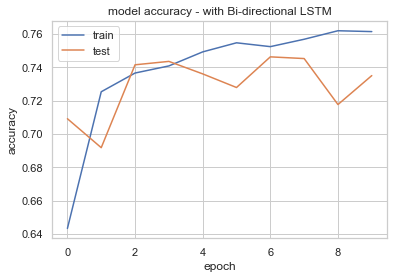

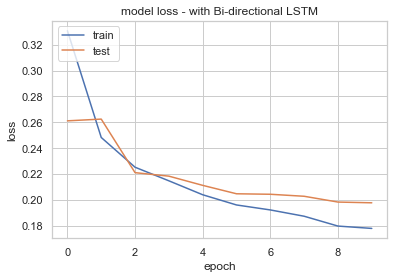

In [31]:
plotmetrics(model_BidirectionalLSTM_his,"with Bi-directional LSTM")

# Step 6: Applying the trained model on unseen test data

In [37]:


test_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/test.csv')
#Remove punctuation

test_respapers['ABSTRACT'] = test_respapers['ABSTRACT'].map(lambda com : clean_text(com))

#decontracting the text()
test_respapers['ABSTRACT'] = test_respapers['ABSTRACT'].apply(lambda x: remove_punctuation(x))

# Print out the first rows of papers
print(test_respapers.head())

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(test_respapers['ABSTRACT'])

X_train = tokenizer.texts_to_sequences(test_respapers['ABSTRACT'])
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
lstm_model = keras.models.load_model(modelpath_BidirectionalLSTM)
Y_pred = lstm_model.predict(X_train)
Y_pred  = np.where(Y_pred > 0.5, 1, 0)
print(Y_pred[2])


      ID                                              TITLE  \
0  20973  Closed-form Marginal Likelihood in Gamma-Poiss...   
1  20974  Laboratory mid-IR spectra of equilibrated and ...   
2  20975         Case For Static AMSDU Aggregation in WLANs   
3  20976  The $Gaia$-ESO Survey: the inner disk intermed...   
4  20977  Witness-Functions versus Interpretation-Functi...   

                                            ABSTRACT  
0  we present novel understandings of the gamma-p...  
1  meteorites contain minerals from solar system ...  
2  frame aggregation is a mechanism by which mult...  
3  milky way open clusters are very diverse in te...  
4  proving that a cryptographic protocol is corre...  
[0 0 1 0 0 0]


In [38]:
myPreds= np.vstack(Y_pred)
print(myPreds[2])

[0 0 1 0 0 0]


In [39]:
for i, col in enumerate(["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]):
    test_respapers[col] = myPreds[:, i]

In [40]:
test_respapers.drop("ABSTRACT", axis=1).to_csv("submissionTwo.csv", index=False)

**Conclusion:**

- Model performs well with Bi-directional LSTM  with high precision and recall for all the labels, but it overfitts for test data

**Future Improvements:**

- Work on the overfitting techniques like  different dropout variations, decay and early stopping methods
- Work on  Balancing the datasets with upsampling or downsampling the data
- Perform Cross validation

**References:**
    
  - https://developpaper.com/python-for-nlp-multi-label-text-lstm-neural-network-classification-using-keras/  
  
  - https://www.kaggle.com/trolukovich/multi-label-classification-keras
  
  - https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
  
  - https://medium.com/swlh/multi-label-text-classification-with-scikit-learn-and-tensorflow-257f9ee30536
    
    